<a href="https://colab.research.google.com/github/kerker83/NLP/blob/main/NLP_imdb_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import SpatialDropout1D
import os
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# login google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Preprocessing

### Hyperparameters

In [4]:
# output directory name
output_dir = '/content/gdrive/MyDrive/Colab Notebooks'

# training
epochs = 4
batch_size = 128

# word vector space
n_dim = 64
n_words_to_skip = 50
n_unique_words = 5000
max_review_length = 400
pad_type = 'pre'
trunc_type = 'pre'
drop_embed = 0.2

# convolution layer
n_conv = 256
k_conv = 3

# dense layer
n_dense = 256
dropout = 0.2

### Load Data

In [5]:
# remove the stop words
(x_train, y_train), (x_test, y_test) = imdb.load_data(skip_top=n_words_to_skip, num_words=n_unique_words)

# set the length of an article the same by padding or truncating
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_test = pad_sequences(x_test, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

17464789/17464789 [==============================] - 0s 0us/step


## Model

In [6]:
model = Sequential()

# this is for DNN
# model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
# model.add(Flatten())
# model.add(Dense(n_dense, activation='relu'))
# model.add(Dropout(dropout))
# model.add(Dense(1, activation='sigmoid'))

model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length))
model.add(SpatialDropout1D(drop_embed))

model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 64)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 398, 256)          49408     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(x_test, y_test), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 83s 414ms/step - loss: 0.4774 - accuracy: 0.7546 - val_loss: 0.3137 - val_accuracy: 0.8637
Epoch 2/4
196/196 [==============================] - 79s 405ms/step - loss: 0.2632 - accuracy: 0.8912 - val_loss: 0.2965 - val_accuracy: 0.8730
Epoch 3/4
196/196 [==============================] - 79s 406ms/step - loss: 0.1906 - accuracy: 0.9267 - val_loss: 0.2988 - val_accuracy: 0.8760
Epoch 4/4
196/196 [==============================] - 80s 410ms/step - loss: 0.1259 - accuracy: 0.9572 - val_loss: 0.3291 - val_accuracy: 0.8772


## Model Evaluating

In [10]:
model.load_weights(output_dir+"/weights.03.hdf5")
y_hat = model.predict(x_test)

782/782 [==============================] - 17s 22ms/step


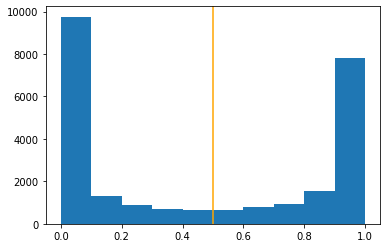

In [11]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

### ROC AUC

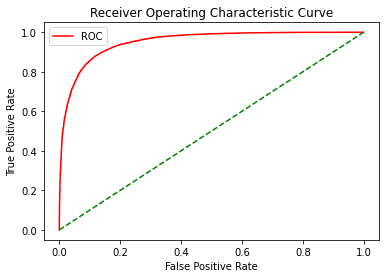

In [12]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

fper, tper, _ = roc_curve(y_test, y_hat)
plot_roc_curve(fper, tper)

In [13]:
pct_auc = roc_auc_score(y_test, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'95.08'